# Pattern Recognition 2 - Feature Space

**Objectives**

* Compute distances between objects in feature space
* Use PCA to perform reduce the dimensionality of the problem
* Implement face recognition using [Eigenfaces](http://en.wikipedia.org/wiki/Eigenface)

## Feature space distance

The `ocr_features.npy` file contains extracted features for each letter from the document used in the previous lab, and the `ocr_class.npy` file contains the character corresponding to these features.

The 18 features, extracted with the `regionprops` methods from `scikit-image` are, in order: 

> area, convex area, eccentricity, equivalent diameter, extent, filled area, intertia tensor eigenvalue 1, inertia tensor eigenvalue 2, major axis length, minor axis length, Hu moment 1, Hu moment 2, Hu moment 3, Hu moment 4, Hu moment 5, Hu moment 6, perimeter, solidity

* Create a method which computes the Euclidian distance, in feature space, between two objects.
* Check if the "nearest" object is of the same class.
* What can you do to improve this "distance-based" classification? 

In [ ]:
import numpy as np

ocr_features = np.load('data/ocr_features.npy')
ocr_class = np.load('data/ocr_class.npy')

print(ocr_features.shape)
print(np.unique(ocr_class))

(2392, 18)
['0' '1' '4' '5' 'A' 'B' 'C' 'D' 'F' 'G' 'I' 'L' 'M' 'N' 'O' 'R' 'S' 'T'
 'W' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r'
 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']


In [4]:
def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

best_matches = []
# 1-NN search
for i in range(ocr_features.shape[0]):
    # compute distances from i to all samples at once
    distances = np.sqrt(
        ((ocr_features - ocr_features[i]) ** 2).sum(axis=1)
    )
    # prevent self-match by setting its distance to the maximum
    distances[i] = distances.max()

    # find index of nearest neighbor
    best_match = distances.argmin()
    best_dist  = distances.min()

    best_matches.append((
        i,
        ocr_class[i],
        best_match,
        ocr_class[best_match],
        best_dist
    ))

best_matches = np.array(best_matches)
# compute 1-NN accuracy:
accuracy = (best_matches[:, 1]==best_matches[:, 3]).sum()/best_matches.shape[0]
print(f"Accuracy: {accuracy:.2%}")

Accuracy: 89.92%


In [5]:
# most of the errors are due to rotation invariant
for matches in best_matches:
    if matches[1] != matches[3]:
        print(matches[1], matches[3])

u n
h w
l 1
a e
F h
L T
l 1
e c
y f
t i
v a
a e
a s
W N
r s
b d
d b
n u
u n
b d
u n
v a
b d
1 l
n u
a s
r i
p d
c e
A w
b d
l 1
n u
b d
u n
R m
a v
u n
M N
L T
l 1
d p
a e
F S
a 4
b d
e c
0 d
5 y
n u
c a
d b
n u
T F
S F
b d
p d
u n
r t
F S
b d
F L
d b
S F
g F
c e
5 c
S F
1 l
n u
b d
u n
u n
n u
o n
h w
a e
p d
d b
v a
4 a
e c
S F
t i
5 e
l 1
b d
I f
a e
u n
f e
d b
r t
p q
d b
T S
d b
F S
e c
s e
n u
n u
k h
F S
e a
1 l
e c
h b
a s
n u
u n
l 1
S F
n u
n u
S F
k 5
n u
k h
n u
n u
n u
I f
e c
a e
a e
n u
t r
x a
a e
1 l
T L
u n
S F
F g
1 l
u n
u n
n u
L F
u n
b h
n u
n u
d p
1 l
d b
n u
T F
t i
n u
a s
d b
n u
n o
F S
u n
u n
1 l
u n
A S
5 h
b d
d p
n u
b d
e 5
n u
e s
v r
c e
s c
p q
e c
1 l
x u
y 5
n u
u n
u n
d b
t i
a s
u n
b d
l 1
h b
S F
n u
e s
t o
e n
n u
u e
p d
o t
e a
e a
t 5
f t
m S
d b
x z
k F
u n
b h
e s
a c
u e
n u
1 l
1 l
n u
e c
d b
u n
n u
q p
n u
u n
F g
f I
p d
b d
a e
D O
d b
d h
d p
n u
F S
x c
4 a
b d
a e
t i
a e
s a
a e
e f
u n


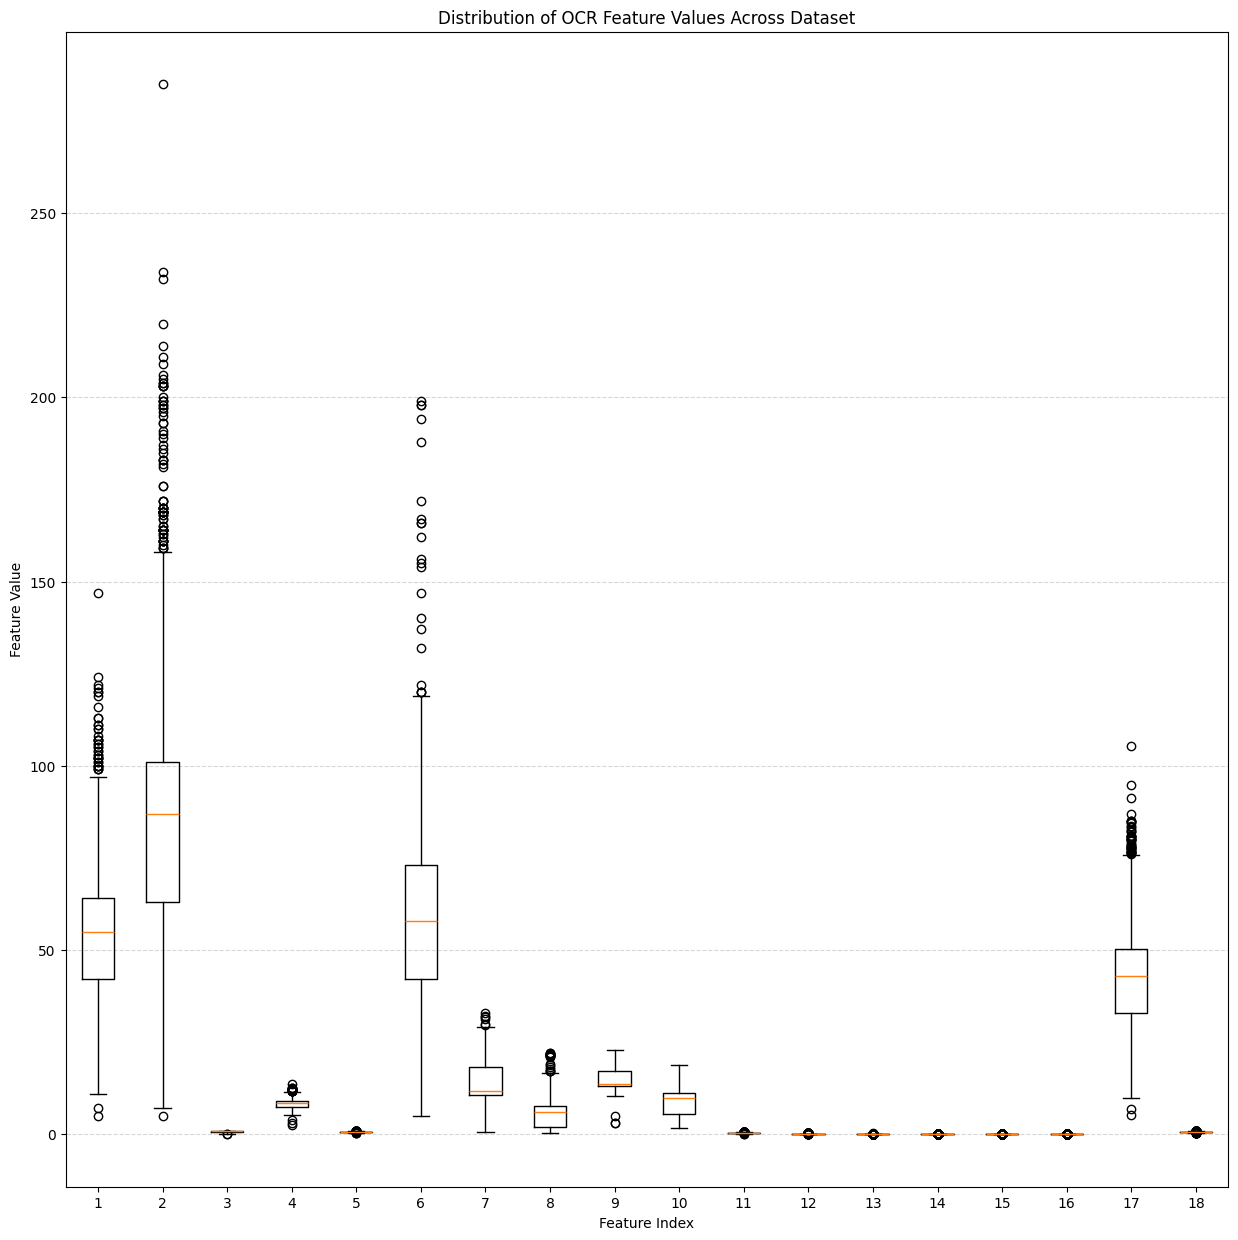

In [7]:
# possible improvements: difference distance metric, Euclidean distance is not suitable when you have many dimensions, data are not normalized - different scales in the dimensions
%matplotlib inline
import matplotlib.pyplot as plt

# plot a box-and-whisker summary of each OCR feature across all samples
plt.figure(figsize=(15, 15))

plt.boxplot(ocr_features)
plt.title("Distribution of OCR Feature Values Across Dataset")
plt.xlabel("Feature Index")
plt.ylabel("Feature Value")
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

In [8]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# standardize features to zero mean and unit variance
scaler = StandardScaler()
features_scaled = scaler.fit_transform(ocr_features)

# perform 1-NN search on the scaled features
best_matches = []

for i in range(features_scaled.shape[0]):
    # compute Euclidean distances
    diffs      = features_scaled - features_scaled[i]
    distances  = np.linalg.norm(diffs, axis=1) 
    # prevent self-match by setting own distance to the maximum
    distances[i] = distances.max()
    
    # find the index of the nearest neighbor
    best_idx = distances.argmin()
    best_dist = distances[best_idx]
    
    best_matches.append((
        i,
        ocr_class[i],
        best_idx,
        ocr_class[best_idx],
        best_dist
    ))

best_matches = np.array(best_matches, dtype=object)

# compute 1-NN accuracy:
accuracy = np.mean(best_matches[:, 1] == best_matches[:, 3])
print(f"1-NN accuracy after scaling: {accuracy:.2%}")

1-NN accuracy after scaling: 95.44%


## Eigenfaces

The `faces.npy` file contains a 3D matrix containing 2963 images, each with 170x200 pixels, encoded in 8-bit grayscale.

In [ ]:
from matplotlib import pyplot as plt

faces = np.load('data/faces.npy')
print(faces.shape, faces.dtype, faces.min(), faces.max())

(2963, 200, 170) uint8 0 255


C:\Users\gianm\AppData\Local\Temp\ipykernel_30280\3801066512.py:3: UserWarning: Reading `.npy` or `.npz` file required additional header parsing as it was created on Python 2. Save the file again to speed up loading and avoid this warning.
  faces = np.load(r'C:\Users\gianm\Documents\Uni\Big Data\H501\exercises\Data\faces.npy')


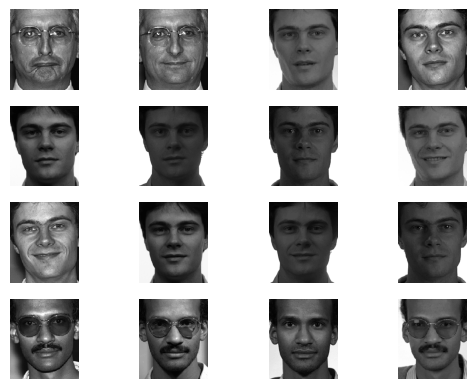

In [122]:
%matplotlib inline
# show some faces
plt.figure()
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(faces[i], cmap=plt.cm.gray)
    plt.axis('off')
plt.show()

### Direct approach

1. Write a program that subsample the images (e.g. by 5), converts 2D images into lines, and collect all these lines into one single matrix **T**.
1. Zero-center **T** by removing the "mean image" ($T_i \leftarrow T_i - T_{mean}$)
1. Compute the variance/covariance matrix of **T**:
$$ \mathbf{S} = \mathbf{T^TT}$$
1. Compute the eigenvalues $\lambda_i$ and eigenvectors $\mathbf{v}_i$ of **S**
$$\mathbf{Sv}_i = \mathbf{T^T}\mathbf{Tv}_i = \lambda_i \mathbf{v}_i$$
1. The eigenvectors have the same size as the images, and are often referred to as "eigenfaces". Display some of them.

In [11]:
# example of eigen value extraction
import numpy as np
import numpy.linalg as LA

w,v = LA.eig(np.diag((1, 2, 3)))
print(w,v)

[1. 2. 3.] [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


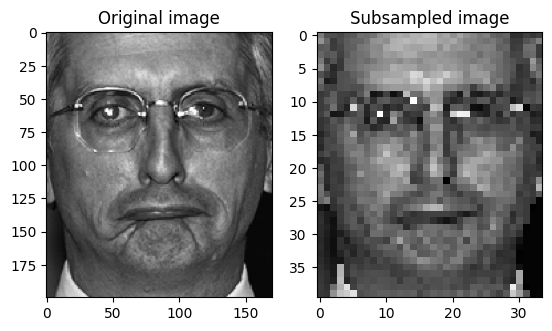

In [12]:
%matplotlib inline
# example of subsampling
im = faces[0]
plt.figure()
plt.subplot(1,2,1)
plt.imshow(im, cmap=plt.cm.gray)
plt.title("Original image")
plt.subplot(1,2,2)
plt.imshow(im[::5,::5], cmap=plt.cm.gray)
plt.title("Subsampled image")
plt.show()

T shape (n_samples × n_pixels): (2963, 1360)
Mean face vector shape: (1360,)


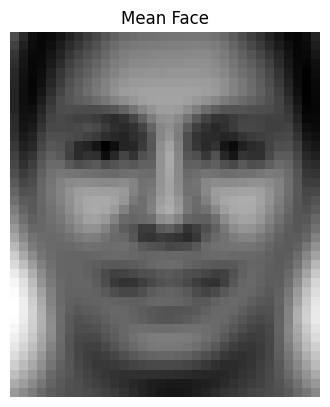

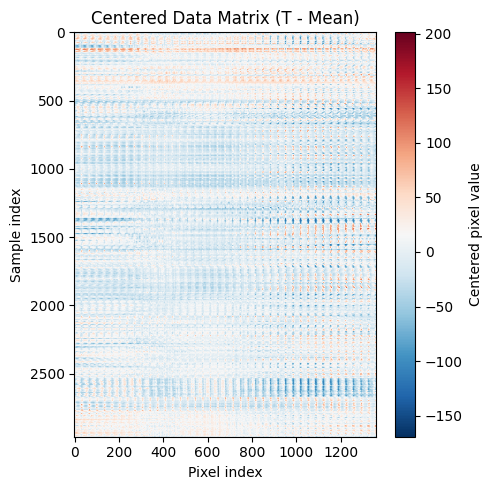

Max absolute column mean: 4.5386966394320325e-13


In [36]:
# subsample each face by a factor of 5 in both dimensions and flatten to a vector
subsample_factor = 5
T = np.array([face[::subsample_factor,::subsample_factor].flatten() for face in faces])
print("T shape (n_samples × n_pixels):", T.shape)

# compute the “mean face” vector (average across all samples)
im_mean = T.mean(axis=0)
print("Mean face vector shape:", mean_face.shape)

# remove mean image from original matrix
T_centered = T - im_mean

# visualize the mean face
h, w = faces[0].shape[0] // subsample_factor, faces[0].shape[1] // subsample_factor
plt.figure(figsize=(4, 5))
plt.imshow(mean_face.reshape(h, w), cmap='gray')
plt.title("Mean Face")
plt.axis('off')
plt.show()

# plot diff from mean image
plt.figure(figsize=(5, 5))
plt.imshow(T_centered, aspect='auto', cmap='RdBu_r')
plt.colorbar(label="Centered pixel value")
plt.title("Centered Data Matrix (T - Mean)")
plt.xlabel("Pixel index")
plt.ylabel("Sample index")
plt.tight_layout()
plt.show()

# verify that each column now has zero mean (up to numerical precision)
col_means = T_centered.mean(axis=0)
print("Max absolute column mean:", np.abs(col_means).max())

In [45]:
# compute var cov matrix
s = np.dot(T_centered.T, T_centered)
print(s.shape)

# cigenvalue, eigenvector decomposition
w, v = LA.eigh(s)
print(w.shape, v.shape)

# sort eigenvalues and eigenvectors in descending order
order = w.argsort()[::-1]
w = w[order]
v = v[:,order]

# compute explained‐variance ratio for each principal component
explained_variance = w/w.sum()

# find how many components are needed for 90% and 95% total explained variance
cum_var = np.cumsum(explained_variance)

# np.searchsorted gives the first index where cum_var >= threshold
n90 = np.searchsorted(cum_var, 0.90) + 1
print(f"{n90} components explain {cum_var[n90-1]:.2%} of variance")

n95 = np.searchsorted(cum_var, 0.95) + 1
print(f"{n95} components explain {cum_var[n95-1]:.2%} of variance")

(1360, 1360)
(1360,) (1360, 1360)
109 components explain 90.04% of variance
248 components explain 95.02% of variance


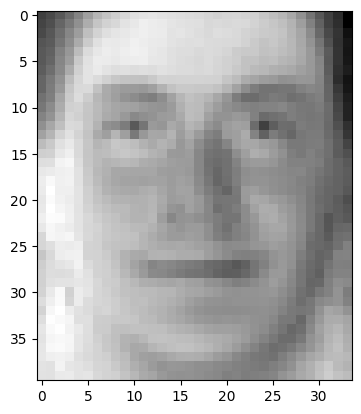

In [46]:
# plot eigenvectors
plt.figure()
plt.imshow(v[:,1].reshape((40, 34)))
plt.show()

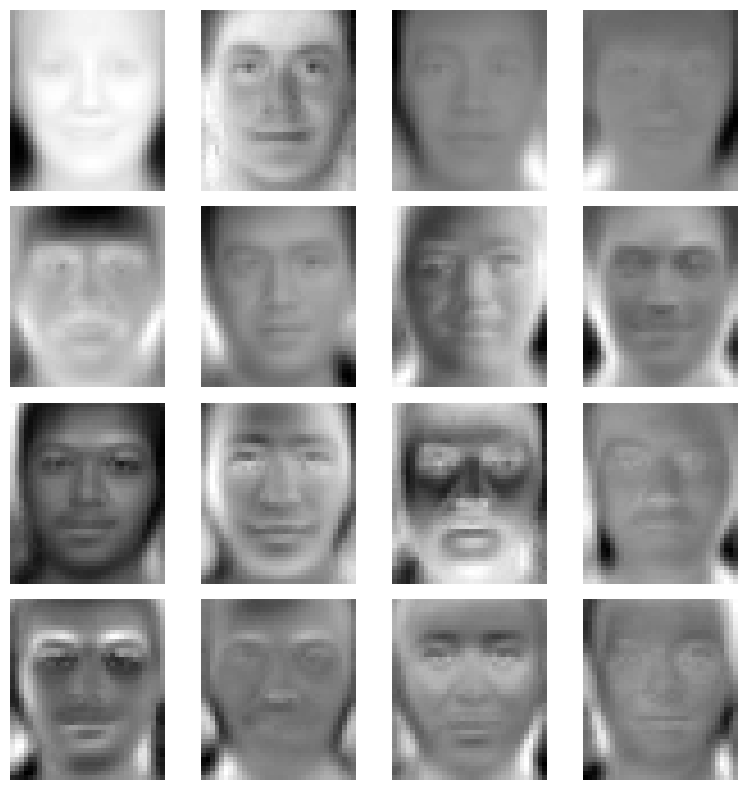

In [51]:
# run for different images

# build data matrix
subsample = 5
n_images  = faces.shape[0]
h = faces.shape[1] // subsample
w = faces.shape[2] // subsample

T = np.zeros((n_images, h*w))
for i in range(n_images):
    T[i, :] = faces[i][::subsample, ::subsample].ravel()

# mean‐center
mean_face = T.mean(axis=0)
T_centered = T - mean_face

# covariance & eigen‐decomp
S = T_centered.T @ T_centered
eigvals, eigvecs = np.linalg.eigh(S)

# sort descending
order = np.argsort(eigvals)[::-1]
eigvecs = eigvecs[:,order]

# plot the first 16 eigenfaces *with normalization*
plt.figure(figsize=(8, 8))
for i in range(16):
    ef = eigvecs[:, i].real.reshape((h, w))
    # normalize to [0,1] for display
    ef_disp = (ef - ef.min()) / (ef.max() - ef.min())
    
    ax = plt.subplot(4, 4, i+1)
    ax.imshow(ef_disp, cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

### Compression

1. Reconstruct images using only the first N eigenfaces (e.g. N=100).
2. Compare (visually) reconstructed images with original images

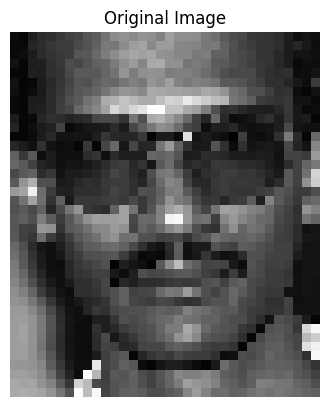

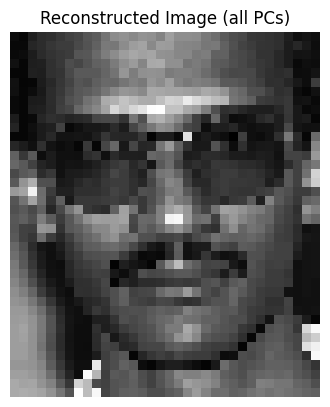

In [52]:
def encode(im, n):
    return np.dot(im, v)[:n]

def decode(encoded, n):
    return np.dot(encoded, v.T[:n])

# pick a sample face (already flattened and mean‐centered)
face = T_centered[12]

# encode with all components
N = len(face)
coeffs_full = encode(face, N)

# decode back to image space
recon_full = decode(coeffs_full, N)

# add back the mean face to get the final pixel values
orig_image = (face + mean_face).reshape((40, 34))
recon_image = ((recon_full + mean_face).real).reshape((40, 34))

# visualize
plt.figure(figsize=(4, 5))
plt.title("Original Image")
plt.imshow(orig_image, cmap='gray')
plt.axis('off')

plt.figure(figsize=(4, 5))
plt.title("Reconstructed Image (all PCs)")
plt.imshow(recon_image, cmap='gray')
plt.axis('off')

plt.show()

### Face recognition

1. Using the simplified vector space (e.g. 100 first eigenfaces), compute the euclidian distance between one face and the others.
2. For a subset of the image of the database, find the 4 closest matches.

In [53]:
# select the top N eigenfaces
N = 100
T_weights = np.array([encode(face, N) for face in T])
print(T_weights.shape)

(2963, 100)


Distance for self-match: 0.0


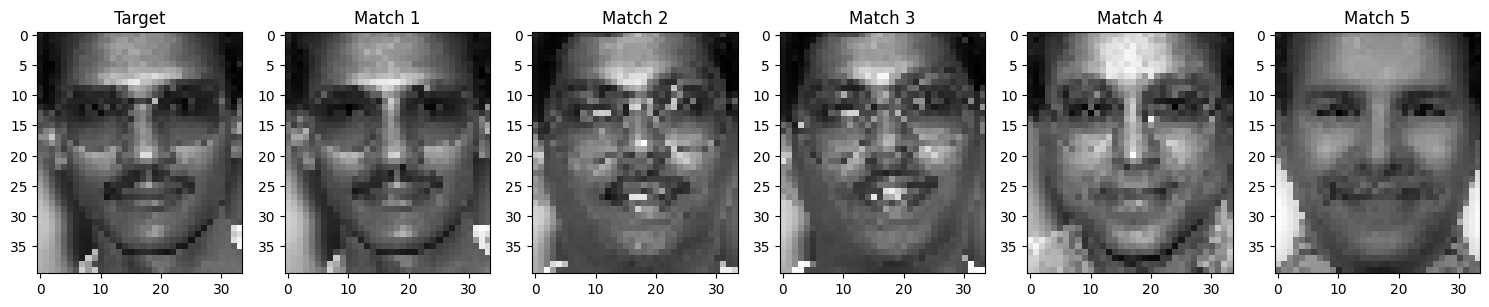

In [55]:
# choose one “probe” face by index
face_id = 12
# compute 1-NN distances in the reduced space
distances = np.sqrt(((T_weights-T_weights[face_id])**2).sum(axis=1))
print("Distance for self-match:", distances[face_id]) # should be 0
distances[face_id] = distances.max() # avoid the trivial self-match

# find indices that sort distances ascendingly
best_matches = np.argsort(distances)

# plot target image + 5 best matches
plt.figure(figsize=(15,15))

# plot the target (probe) image
plt.subplot(1, 6, 1)
plt.imshow((T[face_id] + mean_face).reshape((40,34)), cmap='gray')
plt.title("Target")

# plot top-5 matches
for rank in range(5):
    match_id = best_matches[rank]
    plt.subplot(1, 6, rank+2)
    plt.imshow((T[match_id] + mean_face).reshape((40,34)), cmap='gray')
    plt.title(f"Match {rank+1}")

plt.tight_layout()
plt.show()

### Indirect approach

Instead of using the eigenvalues/eigenvectors of $\mathbf{S} = \mathbf{T^TT}$, compute the the eigenvalues/eigenvectors of $\mathbf{Q} = \mathbf{TT^T}$.

Let $\mathbf{u_i}$ be the eigenvectors of $\mathbf{Q}$. We have:
$$\mathbf{TT^T}\mathbf{u}_i = \lambda_i \mathbf{u}_i$$

By multiplying to the left with $\mathbf{T^T}$, we have:
$$\mathbf{T^T}\mathbf{TT^T}\mathbf{u}_i = \lambda_i\mathbf{T^T}\mathbf{u}_i$$
$$\mathbf{S}\mathbf{T^T}\mathbf{u}_i = \lambda_i\mathbf{T^T}\mathbf{u}_i$$

Which means that if $\mathbf{u}_i$ is eigenvector of $\mathbf{Q}$, then $\mathbf{T^T}\mathbf{u}_i$ is eigenvector of $\mathbf{S}$.

The indirect approach thus becomes:
1. Compute the eigenvectors $\mathbf{u}_i$ of $\mathbf{Q} = \mathbf{TT^T}$.
1. Compute the eigenfaces with $\mathbf{v}_i = \mathbf{T^T}\mathbf{u}_i$ 
1. Reconstruct the images using only the first N eigenfaces (e.g. N=100)
1. Compare (visually) reconstructed images with original images
1. Use the indirect approach with more resolution (without subsampling the images)

Use this new feature space to perform the same face recognition method.

In [59]:
# compute the matrix Q = T T^T
Q = np.dot(T, T.T)
print("Q shape:", Q.shape)

# compute eigenvalues and eigenvectors of Q
lambda_vals, u = np.linalg.eigh(Q)

# sort the eigenvalues and eigenvectors in descending order
order = np.argsort(lambda_vals)[::-1]
lambda_vals = lambda_vals[order]
u = u[:, order]

# compute the eigenfaces from the eigenvectors of Q.
V = np.dot(T.T, u)  # V is of shape (n_features, n_images)

# normalize each eigenface so that it has unit norm
norms = np.linalg.norm(V, axis=0)
V = V / norms

Q shape: (2963, 2963)


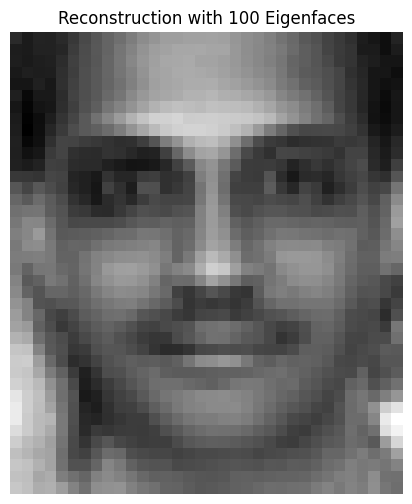

In [60]:
# select the top N eigenfaces
N = 100 
V_N = V[:, :N]  # matrix of eigenfaces of shape (n_features, N)

# project the (mean-subtracted) images into this new feature space.
T_weights = np.dot(T, V_N)  # shape: (n_images, N)

# reconstruct images using the top N eigenfaces
face_id = 12
reconstructed_face = np.dot(T_weights[face_id], V_N.T) # reconstruction in eigenface space
reconstructed_face += im_mean # add the mean image back to get the final reconstruction.

# Plot reconstructed face
plt.figure(figsize=(6, 6))
plt.imshow(
    reconstructed_face.reshape((40, 34)),
    cmap='gray'
)
plt.title(f"Reconstruction with {N} Eigenfaces")
plt.axis('off')
plt.show()

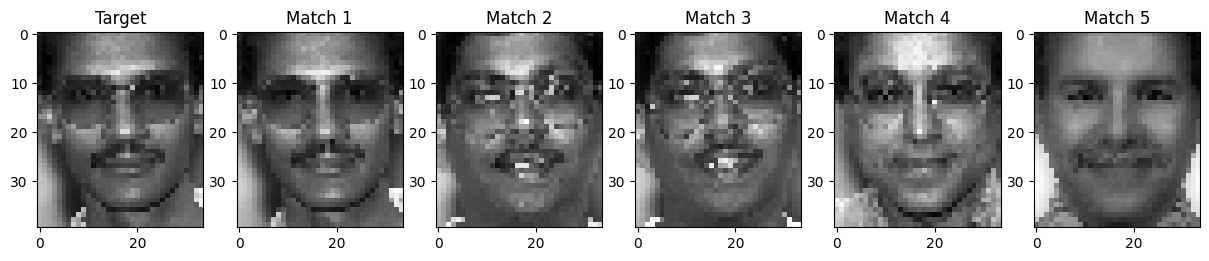

In [61]:
# use new feature space for recognition
# compare a target image’s weights with all images’ weights
target_id = face_id  # for example, choose the same image (or a different one)
target_weights = T_weights[target_id]
distances = np.linalg.norm(T_weights - target_weights, axis=1)
distances[target_id] = distances.max()   # avoid the trivial self-match
best_match_indices = np.argsort(distances)

# plot target image + best matches
plt.figure(figsize=(15, 15))
plt.subplot(1, 6, 1)
plt.imshow(T[target_id].reshape((40, 34)) + im_mean.reshape((40, 34)), cmap='gray')
plt.title("Target")
for i in range(5):
    plt.subplot(1, 6, i + 2)
    plt.imshow(T[best_match_indices[i]].reshape((40, 34)) + im_mean.reshape((40, 34)), cmap='gray')
    plt.title("Match " + str(i + 1))
plt.show()